## Librerias

In [388]:
import pandas as pd
import numpy as np
import urllib.request
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor                                # Alta precision y rendimiento. Incorpora regularización
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report


## Data

In [389]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("data/train.csv", index_col = 0)
df.index.name = None

## Data exploration

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [391]:
df.describe()

,Inches,Price_in_euros
count,912.000000,912.000000
mean,14.981579,1111.724090
std,1.436719,687.959172
min,10.100000,174.000000
25%,14.000000,589.000000
50%,15.600000,978.000000
75%,15.600000,1483.942500
max,18.400000,6099.000000


In [392]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [393]:
features_num = "Inches"
features_cat = [col for col in df if col not in features_num]

## Data processing

El target es la columna `Price_in_euros`

In [394]:
df["inches"] = df.Inches.astype(float)
df['ram_gb'] = df['Ram'].str.replace('GB', '').astype(int)
df["weight_kg"] = df['Weight'].str.replace('kg', '').astype(float)
df["Memory_num"] = df['Memory'].str.extract('(\d+)').astype(int)
df['Memory_num'] = df['Memory_num'].replace(1, 1000)
df['Memory_num'] = df['Memory_num'].replace(2, 2000)
df['Memory_num'] = df['Memory_num'].replace(8, 8000)

In [395]:
mapeo_type = {
    "Notebook": 1,
    "Gaming": 2,
    "Ultrabook": 3,
    "2 in 1 Convertible": 4,
    "Workstation": 5,
    "Netbook": 6}

df['TypeName_num'] = df['TypeName'].copy()
df["TypeName_num"] = df["TypeName_num"].map(mapeo_type)

In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
 12  inches            912 non-null    float64
 13  ram_gb            912 non-null    int64  
 14  weight_kg         912 non-null    float64
 15  Memory_num        912 non-null    int64  
 16  TypeName_num      912 non-null    int64  
dtype

-----------------------------------------------------------------------------------------------------------------

In [397]:
df.sample(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,inches,ram_gb,weight_kg,Memory_num,TypeName_num
279,Toshiba,Satellite Pro,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,8GB,500GB HDD,Nvidia GeForce 930M,Windows 10,2.2kg,812.00,15.6,8,2.20,500,1
719,Dell,Latitude 5480,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7440HQ 2.8GHz,8GB,256GB SSD,Nvidia GeForce 930MX,Linux,1.64kg,1089.00,14.0,8,1.64,256,1
528,HP,Spectre X360,Ultrabook,13.3,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.32kg,1399.00,13.3,8,1.32,256,3
354,Asus,VivoBook Flip,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Celeron Dual Core N3350 1.1GHz,4GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.5kg,375.00,11.6,4,1.50,32,4
89,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.96kg,598.99,15.6,8,1.96,256,1


## Modelado

### 1. Definir X e y

In [398]:
X = df.iloc[:, 12:].copy()
y = df['Price_in_euros'].copy()
X.shape

(912, 5)

In [399]:
X

,inches,ram_gb,weight_kg,Memory_num,TypeName_num
755,15.6,8,1.86,256,1
618,15.6,16,2.59,1000,2
909,15.6,8,2.04,1000,1
2,13.3,8,1.34,128,3
286,15.6,4,2.25,1000,1
...,...,...,...,...,...
28,15.6,8,2.20,256,1
1160,13.3,8,1.48,256,4
78,15.6,8,2.20,2000,1
23,15.6,4,1.86,500,1


In [400]:
y

755      539.00
618      879.01
909      900.00
2        898.94
286      428.00
         ...   
28       800.00
1160    1629.00
78       519.00
23       258.00
229     2456.34
Name: Price_in_euros, Length: 912, dtype: float64

### 2. Dividir X_train, X_test, y_train, y_test

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [402]:
X_train

,inches,ram_gb,weight_kg,Memory_num,TypeName_num
1118,17.3,8,3.00,1000,5
153,15.6,16,2.56,512,2
275,13.3,8,1.37,512,3
1100,14.0,4,1.54,500,1
131,17.3,16,2.80,256,1
...,...,...,...,...,...
578,14.0,8,1.94,2000,1
996,15.6,6,2.20,256,1
770,12.5,16,1.18,256,3
407,15.6,4,2.20,1000,1


In [403]:
y_train

1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: Price_in_euros, Length: 729, dtype: float64

In [404]:
'''from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Llamamos al método
scaler = StandardScaler()

# Adaptamos el StandarScaler al X_train, pero luego usamos el mismo en el X_test (porque ya la media y la desviación son las del X_train)		
X_train_scal = scaler.fit_transform(X_train)

# Para pintar, convertimos a dataframe
X_train_scal_df = pd.DataFrame(X_train_scal)
X_train_scal_df.hist(bins=30, figsize=(20,10), edgecolor='black');
plt.tight_layout()'''

"from sklearn.preprocessing import StandardScaler\nimport matplotlib.pyplot as plt\n\n# Llamamos al método\nscaler = StandardScaler()\n\n# Adaptamos el StandarScaler al X_train, pero luego usamos el mismo en el X_test (porque ya la media y la desviación son las del X_train)\t\t\nX_train_scal = scaler.fit_transform(X_train)\n\n# Para pintar, convertimos a dataframe\nX_train_scal_df = pd.DataFrame(X_train_scal)\nX_train_scal_df.hist(bins=30, figsize=(20,10), edgecolor='black');\nplt.tight_layout()"

### 3. Baseline de modelos


In [405]:
from sklearn.model_selection import cross_val_score

# Lista de nombres de modelos
modelos = ["RandomForestRegressor", "XGBRegressor", "GradientBoostingRegressor", "KNN"]
metricas = []

# Instanciación de los modelos
rnd_reg = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rnd_reg.fit(X_train, y_train)

xgb_reg = XGBRegressor(max_depth = 5, n_estimators= 100)
xgb_reg.fit(X_train, y_train)

gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train, y_train)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)


# Bucle para evaluar los modelos
for nombre, modelo in zip(modelos, [rnd_reg, xgb_reg, gb_reg, knn_reg]):
    print(f"Para {nombre}:", end=" ")
    
    # Cross validation con métrica de regresión adecuada
    metrica_neg = np.mean(cross_val_score(modelo, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))
    
    # Convertimos métrica a positiva
    metrica_pos = np.sqrt(-metrica_neg)

    # Imprimir la métrica
    print(metrica_pos)
    
    # Añadir la métrica a la lista
    metricas.append(metrica_pos)

Para RandomForestRegressor: 355.48059913498315
Para XGBRegressor: 369.40770614106856
Para GradientBoostingRegressor: 344.290830415305
Para KNN: 393.7275302086815


In [406]:
'''knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_scal, y_train)

# Realizar validación cruzada (5-fold)
rmse_scores = np.sqrt(-cross_val_score(knn_reg, X_train_scal, y_train, scoring="neg_mean_squared_error", cv=5))

# Imprimir el RMSE promedio y su desviación estándar
print("RMSE promedio en validación cruzada:", rmse_scores.mean())'''

'knn_reg = KNeighborsRegressor(n_neighbors=5)\nknn_reg.fit(X_train_scal, y_train)\n\n# Realizar validación cruzada (5-fold)\nrmse_scores = np.sqrt(-cross_val_score(knn_reg, X_train_scal, y_train, scoring="neg_mean_squared_error", cv=5))\n\n# Imprimir el RMSE promedio y su desviación estándar\nprint("RMSE promedio en validación cruzada:", rmse_scores.mean())'

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de RMSE.

In [407]:
from sklearn.model_selection import GridSearchCV

In [408]:
'''param_grid = {
    "n_estimators": [100,200,400], 				# Ensablados como RandomForest o LightGBM
    "max_depth": [2,4,8, None]}

grid_xgb_reg = GridSearchCV(xgb_reg,
                           param_grid,
                           scoring = "neg_mean_squared_error", 		# Métrica que quiero optimizar
                           cv = 5)							        # Nº de iteraciones del algoritmo'''

'param_grid = {\n    "n_estimators": [100,200,400], \t\t\t\t# Ensablados como RandomForest o LightGBM\n    "max_depth": [2,4,8, None]}\n\ngrid_xgb_reg = GridSearchCV(xgb_reg,\n                           param_grid,\n                           scoring = "neg_mean_squared_error", \t\t# Métrica que quiero optimizar\n                           cv = 5)\t\t\t\t\t\t\t        # Nº de iteraciones del algoritmo'

In [409]:
'''param_grid = {
    "n_estimators": [100,200,400], 				# Ensablados como RandomForest o LightGBM
    "max_depth": [2,4,8, None]}

grid_rndforest_reg = GridSearchCV(rnd_reg,
                           param_grid,
                           scoring = "neg_mean_squared_error", 		# Métrica que quiero optimizar
                           cv = 5)							        # Nº de iteraciones del algoritmo

grid_rndforest_reg.fit(X_train, y_train)'''

'param_grid = {\n    "n_estimators": [100,200,400], \t\t\t\t# Ensablados como RandomForest o LightGBM\n    "max_depth": [2,4,8, None]}\n\ngrid_rndforest_reg = GridSearchCV(rnd_reg,\n                           param_grid,\n                           scoring = "neg_mean_squared_error", \t\t# Métrica que quiero optimizar\n                           cv = 5)\t\t\t\t\t\t\t        # Nº de iteraciones del algoritmo\n\ngrid_rndforest_reg.fit(X_train, y_train)'

In [410]:
rf_2 = RandomForestRegressor()

param_grid = {
    'n_estimators': [100,125, 150],        # Número de árboles en el bosque
    'max_depth': [4, 5, 6],             # Profundidad máxima de cada árbol
    'min_samples_split': [2, 3]}

# Instanciar GridSearchCV
grid_search = GridSearchCV(estimator=rf_2, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=0)

# Ajustar el modelo a los datos
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor RMSE
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

# Imprimir resultados
print("Mejores hiperparámetros:", best_params)
print("Mejor RMSE:", best_rmse)

Mejores hiperparámetros: {'max_depth': 6, 'min_samples_split': 3, 'n_estimators': 100}
Mejor RMSE: 346.6355975196103


In [411]:
rnd_reg = RandomForestRegressor(n_estimators=150, max_depth=6, min_samples_split = 2)
rnd_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=150)

In [412]:
'''from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scal, y_train)

# Hacer predicciones
y_pred = lin_reg.predict(X_test)

'''

'from sklearn.linear_model import LinearRegression\n\nlin_reg = LinearRegression()\nlin_reg.fit(X_train_scal, y_train)\n\n# Hacer predicciones\ny_pred = lin_reg.predict(X_test)\n\n'

In [413]:
param_grid = {
    'n_estimators': [100,125, 150],        # Número de árboles en el bosque
    'max_depth': [4, 5, 6],             # Profundidad máxima de cada árbol
    'min_samples_split': [2, 3]}

# Instanciar GridSearchCV
grid_search = GridSearchCV(estimator=gb_reg, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=0)

# Ajustar el modelo a los datos
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor RMSE
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

# Imprimir resultados
print("Mejores hiperparámetros:", best_params)
print("Mejor RMSE:", best_rmse)

Mejores hiperparámetros: {'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 100}
Mejor RMSE: 336.5256936277788


In [414]:
gb_reg = GradientBoostingRegressor(n_estimators=125, max_depth=4, min_samples_split = 2)
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=125)

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [415]:
X_pred = pd.read_csv("data/test.csv", index_col = 0)
X_pred.index.name = None
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [416]:
X_pred.shape

(391, 11)

In [417]:
X_pred.to_csv('Biodatos.csv')

In [418]:
X_pred["inches"] = X_pred.Inches.astype(float)
X_pred['ram_gb'] = X_pred['Ram'].str.replace('GB', '').astype(int)
X_pred["weight_kg"] = X_pred['Weight'].str.replace('kg', '').astype(float)
X_pred["Memory_num"] = X_pred['Memory'].str.extract('(\d+)').astype(int)
X_pred['Memory_num'] = X_pred['Memory_num'].replace(1, 1000)
X_pred['Memory_num'] = X_pred['Memory_num'].replace(2, 2000)
X_pred['Memory_num'] = X_pred['Memory_num'].replace(8, 8000)


In [419]:
mapeo_type = {
    "Notebook": 1,
    "Gaming": 2,
    "Ultrabook": 3,
    "2 in 1 Convertible": 4,
    "Workstation": 5,
    "Netbook": 6}

X_pred['TypeName_num'] = X_pred['TypeName'].copy()
X_pred["TypeName_num"] = X_pred["TypeName_num"].map(mapeo_type)

In [420]:
X_pred = X_pred.iloc[:, 11:]

In [421]:
X_pred.head()

,inches,ram_gb,weight_kg,Memory_num,TypeName_num
209,15.6,16,2.400,512,2
1281,15.6,4,2.400,500,1
1168,15.6,4,1.900,1000,1
1231,15.6,8,2.191,256,4
1020,14.0,4,1.950,256,1


In [422]:
X_train.head()

,inches,ram_gb,weight_kg,Memory_num,TypeName_num
1118,17.3,8,3.00,1000,5
153,15.6,16,2.56,512,2
275,13.3,8,1.37,512,3
1100,14.0,4,1.54,500,1
131,17.3,16,2.80,256,1


In [423]:
predictions_submit = gb_reg.predict(X_pred)
predictions_submit

array([1572.5438933 ,  471.33545798,  515.8867387 , 1117.20419264,
        941.10660486,  653.40126408,  785.35617215, 1001.56203107,
       1365.99642107,  308.59495695, 2355.05551699, 1669.55916956,
        517.94545344, 1677.82239969, 1019.13849651,  480.93426397,
       2192.90548243, 1405.56299449, 1735.21463637,  659.59403245,
       1538.37248544,  259.71369958,  743.05210571, 1685.74424937,
        512.82657743,  637.98726482,  726.83495728, 1089.96952706,
       2504.74961752, 1047.56222253, 1955.19228389,  448.10032493,
        959.69599805, 3092.17145971, 2121.08359419, 1953.59738082,
        500.30735159, 1592.68020675,  915.29848103, 1642.71469003,
        682.89548919, 1224.41035505,  562.96671886, 1047.56222253,
       1630.30855005, 1122.26340631, 1003.79216722,  497.6882414 ,
        875.93567024,  507.51563487, 2220.74842054,  637.98726482,
       1098.61690096,  476.56951888, 1556.94688444, 1862.50023595,
        595.02917401,  698.77018663, 1216.01231743,  584.25151

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [424]:
# ¿Qué opináis?
# ¿Sí, no?

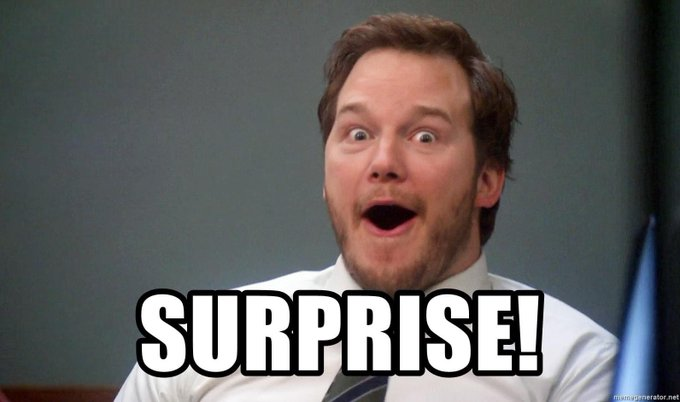

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [425]:
sample = pd.read_csv("./data/sample_submission.csv")

In [426]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [427]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [428]:
submission = pd.DataFrame({"laptop_ID": X_pred.index, "Price_in_euros": predictions_submit})

In [429]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1572.543893
1,1281,471.335458
2,1168,515.886739
3,1231,1117.204193
4,1020,941.106605


In [430]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [431]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

In [433]:
chequeador(submission)

You're ready to submit!
